In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML

A raw cleaning of data results in a table including these columns. Here we present the first record to illustrate the datatype of each feature.

In [2]:
cdf = pd.read_csv("../Preprocess/cdf_update.csv") # baseline
cdf_raw = pd.read_csv("cdf_withJoint.csv") # balanced class
cdf.iloc[1]

loan_amnt                                   8000
funded_amnt                                 8000
term                                          36
int_rate                                   10.75
installment                               260.97
grade                                          B
emp_title                                 driver
emp_length                                     8
home_ownership                              RENT
annual_inc                                 34000
verification_status                            1
issue_d                                 Mar-2016
loan_status                                    1
purpose                       debt_consolidation
zip_code                                   910xx
addr_state                                    CA
dti                                        23.12
delinq_2yrs                                    1
earliest_cr_line                        Aug-2005
pub_rec                                        0
revol_util          

In [3]:
df = cdf.copy()
y_data = df["loan_status"]

## Principal Component Analysis

In [4]:
num_x_raw = df.loc[:,df.dtypes != "object"]

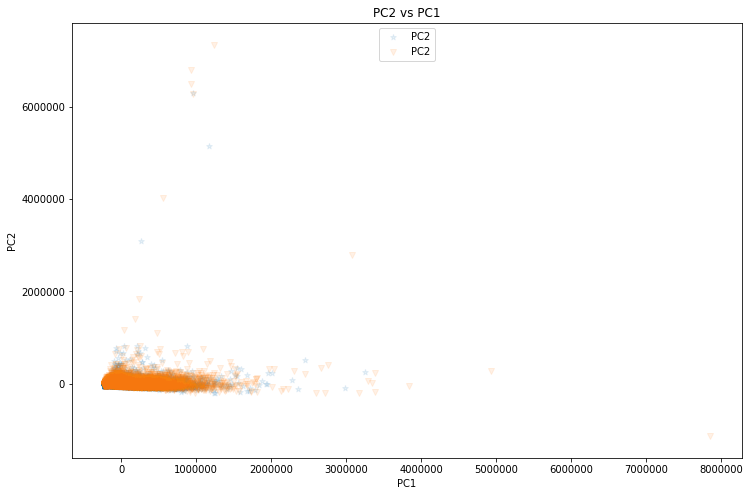

In [5]:
pca = PCA(n_components=2).fit(num_x_raw)
principalComponents = pca.transform(num_x_raw)
principalDf = pd.DataFrame(data = principalComponents, columns=["PC1","PC2"])
markers = ["*","v"]
plt.figure(figsize=[12,8])
for ylabel in [0,1]:
    df0 = principalDf[np.array(y_data) == ylabel]
    plt.scatter(x = df0["PC1"], y = df0["PC2"], marker = markers[ylabel], alpha = 0.1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc='upper center')
plt.title("PC2 vs PC1")
plt.show()

Therefore PCA indicates that the data is not well-separable.

## Assessing Co-linearity

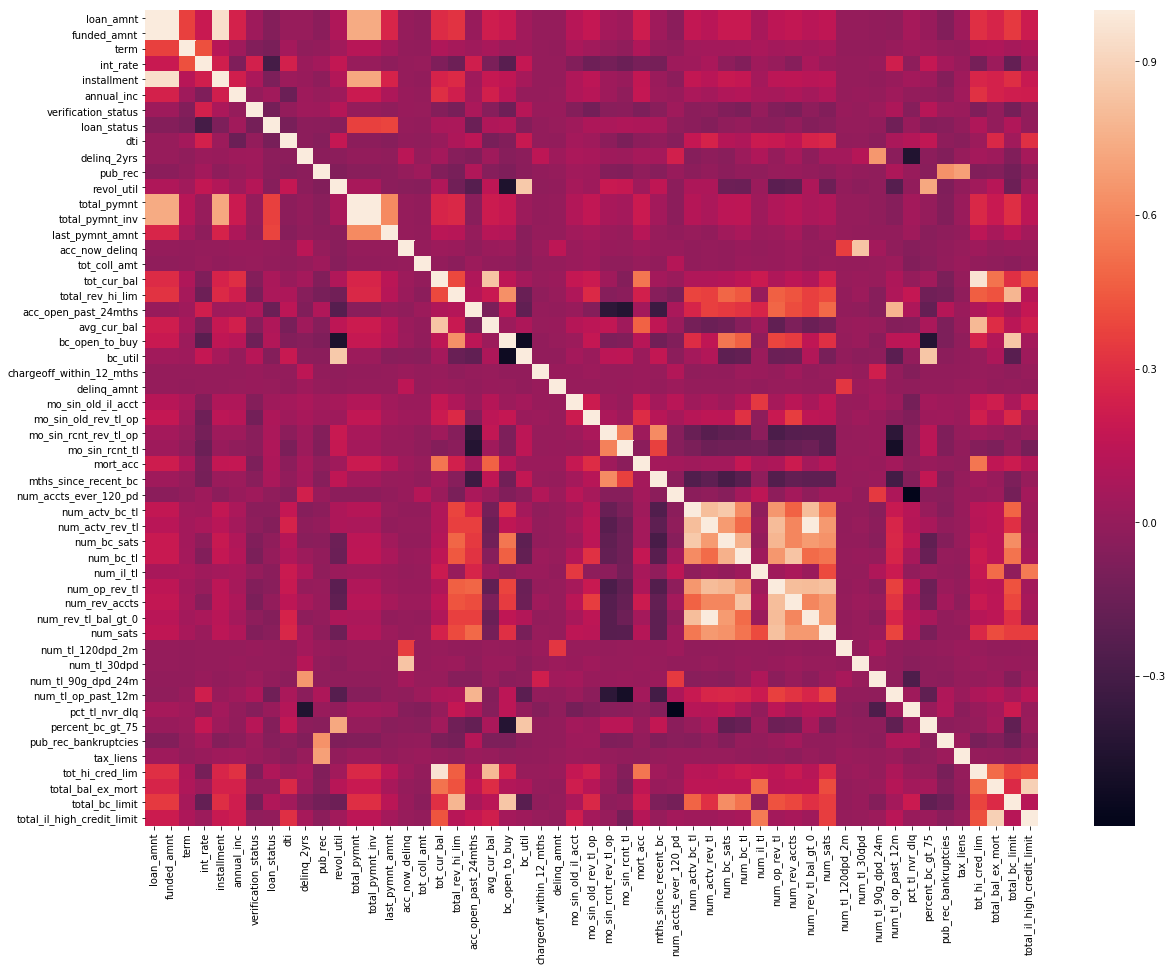

In [6]:
plt.figure(figsize = (20,15))
sns.heatmap(num_x_raw.corr())
plt.show()

It seems that for the revolving account we are having problem with colinearity. We later proposed to remove feature that has > 0.9 correlation with any other feature.

## Summarising features

Here we want to see what features have different distribution between two classes, those features might be of predictive value, or be directly related to loan status class itself. The latter one is really problematic.

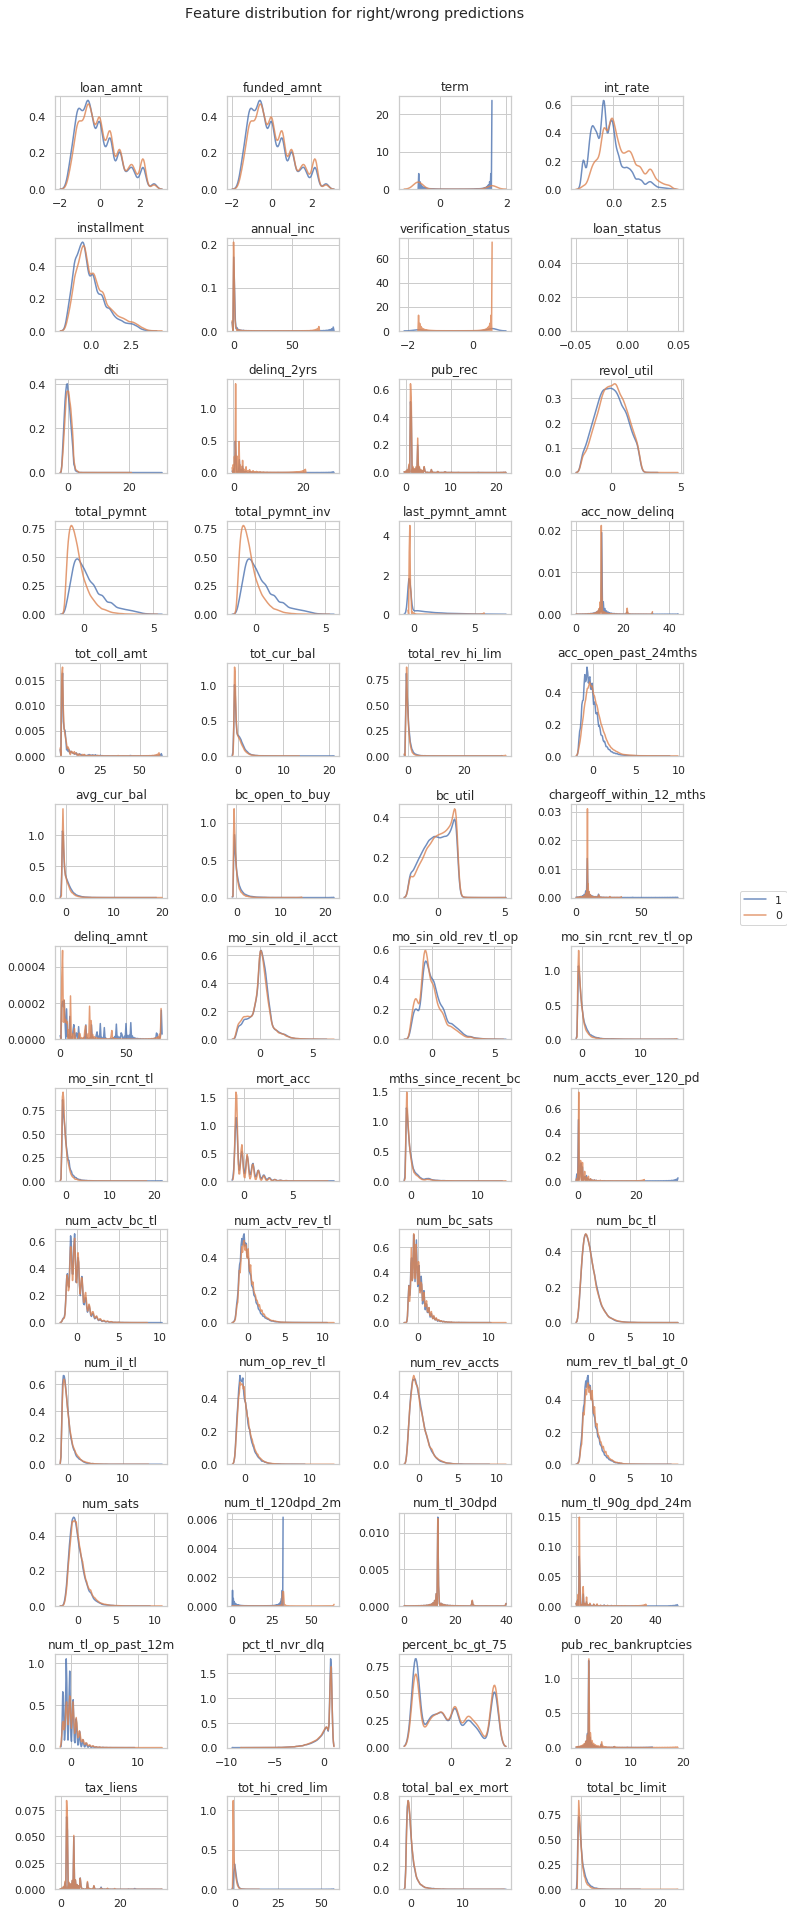

In [26]:
from sklearn.preprocessing import StandardScaler

if_right = np.array(y_data) == 1
nparr = np.array(num_x_raw)
columns = num_x_raw.columns.tolist()


min_max_scaler = StandardScaler()
nparr = min_max_scaler.fit_transform(nparr)

fig, axs = plt.subplots(ncols=4, nrows=13, figsize = [10,28],sharex=False)
axs = axs.flatten()
for i, ax in enumerate(axs):
    predictor = nparr[:,i]
    pname = columns[i]
    d1 = predictor[if_right]
    d2 = predictor[np.logical_not(if_right).tolist()]
    ax.set_title(pname)
    sns.kdeplot(ax=ax, data=d1,label="1", alpha=0.8)
    sns.kdeplot(ax=ax, data=d2, label="0", alpha=0.8)
    ax.get_legend().set_visible(False)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='right', bbox_to_anchor=(1.1, 0.5))
fig.suptitle("Feature distribution for right/wrong predictions")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
#fig.subplots_adjust(left=0.5, bottom=0, right=1, top=1.5, wspace=0.5, hspace=0.5)
plt.show()

Here we identified some variables that could never be obtained when a loan was initiated (posted on lending club), like last_payment_amount, total_payment. We must not include them in the model.

### Feature exploration

- **Q1: Loan status distribution in each state?**

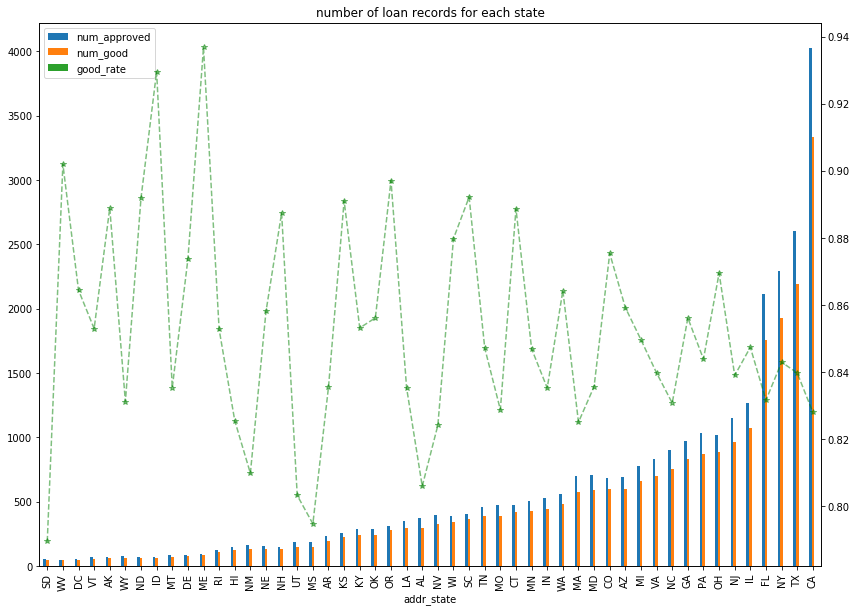

In [8]:
num_of_approved = cdf_raw.groupby("addr_state").count()["loan_amnt"]
num_of_good_status = cdf_raw.groupby("addr_state").sum()["loan_status"]
df_state = pd.concat([num_of_approved, num_of_good_status], axis=1)
df_state = df_state.rename(index=str, columns={"loan_status": "num_good", "loan_amnt": "num_approved"})
df_state = df_state.sort_values(by=['num_good'])
df_state["good_rate"] = df_state["num_good"]/df_state["num_approved"]

fig, ax1 = plt.subplots()
df_state.plot.bar(figsize=(14,10), title="number of loan records for each state", ax=ax1)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.plot(df_state["good_rate"],  'g--*', alpha=0.5)
plt.show()

There seems some discrimination among states. For example, CA receives the most loans but it does not have nice rate of returning money in time. It might be due to the population imbalance in each state, but there might be other attributable causes. We will assess that further.

- **Q2: How credit level and annual income relates to loan status?**

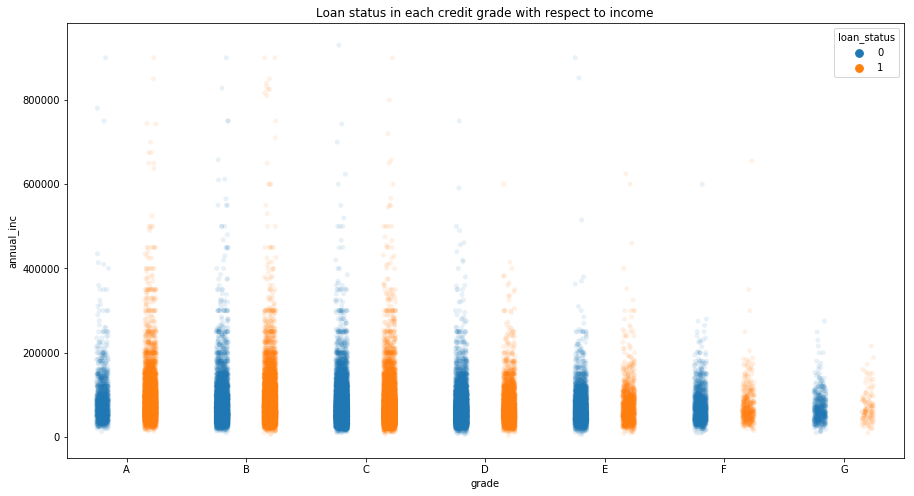

In [9]:
df_cut = df[df["annual_inc"]<1000000]
plt.figure(figsize=[15,8])
sns.stripplot(x="grade", y="annual_inc", hue=y_data, 
              data=df_cut, jitter=True, alpha=0.1, dodge=True,
              order=['A','B','C','D','E','F','G'])
plt.title("Loan status in each credit grade with respect to income")
plt.show()

From this plot we could see that, higher income does not necessarily indicates higher credit grade.
For first two classes (A and B), there are more successful returns (1) than unseccessful ones (0). The proportion of 0 and 1 are getting equal in credit class C but 0 is more frequent than 1 in later credit categories. 

**Q3: How home ownership affects initial rate, and final loan status?**

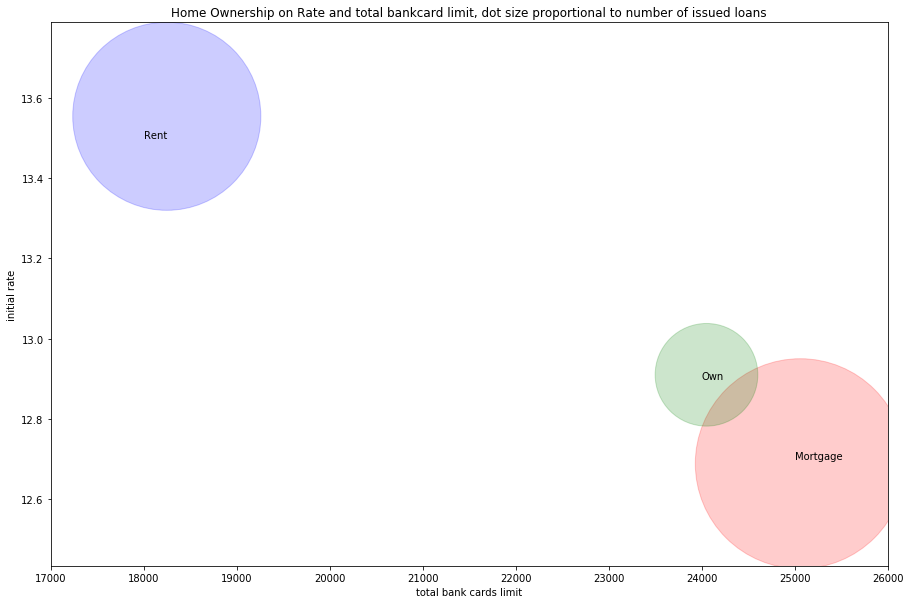

In [10]:
df_home = cdf_raw.groupby("home_ownership").mean()[["int_rate","total_bc_limit"]]
df_home["number"] = cdf_raw["home_ownership"].value_counts()
plt.figure(figsize=[15,10])
plt.xlim([17000, 26000])
plt.scatter(df_home["total_bc_limit"],df_home["int_rate"], 
            s = df_home["number"]*3, alpha = 0.2, c=['r','g','b']
           )
plt.text(x=18000, y = 13.5, s = "Rent")
plt.text(x=24000, y = 12.9, s = "Own")
plt.text(x=25000, y = 12.7, s = "Mortgage")
plt.title("Home Ownership on Rate and total bankcard limit, dot size proportional to number of issued loans")
plt.xlabel("total bank cards limit")
plt.ylabel("initial rate")
plt.show()

Here we could see that, the people who owned their house or put houses on mortgage are having smaller rate compared to those who rent their house. Maybe they are belived to have better budgeting habits. The majority of people who are approved for lending club are in either mortgage of rent category.